In [184]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade hyperopt
!pip install --upgrade hpsklearn
!pip install --upgrade seaborn

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: hyperopt in c:\anaconda\lib\site-packages (0.1.1)
Requirement already up-to-date: hpsklearn in c:\anaconda\lib\site-packages (0.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)


In [185]:
#import common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
import glob

#from scipy import interp
sns.set(font_scale=1.3)

In [50]:
#import special libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, recall_score, brier_score_loss
from sklearn.metrics import f1_score, make_scorer, precision_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD,IncrementalPCA

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.calibration import CalibratedClassifierCV, calibration_curve


%matplotlib inline

In [51]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [265]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Итак, задача данной работы:



#### EDA.

Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных

In [829]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [387]:
def generate_stat_df(df,df_type):
    unique, counts = np.unique(df.target, return_counts=True)

    df_print = pd.DataFrame(data=list(zip(unique, df.target_names, counts)), 
                            columns = ['Id_category', 'Category_Name', 'N_texts'])
    df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0]
    df_print['Dataset_Type'] = df_type
    return df_print

df_summary = generate_stat_df(train_texts, 'train')
df_summary = df_summary.append(generate_stat_df(test_texts, 'test'), ignore_index=True)
df_summary = df_summary.append(generate_stat_df(newsgroups_all, 'all'), ignore_index=True)

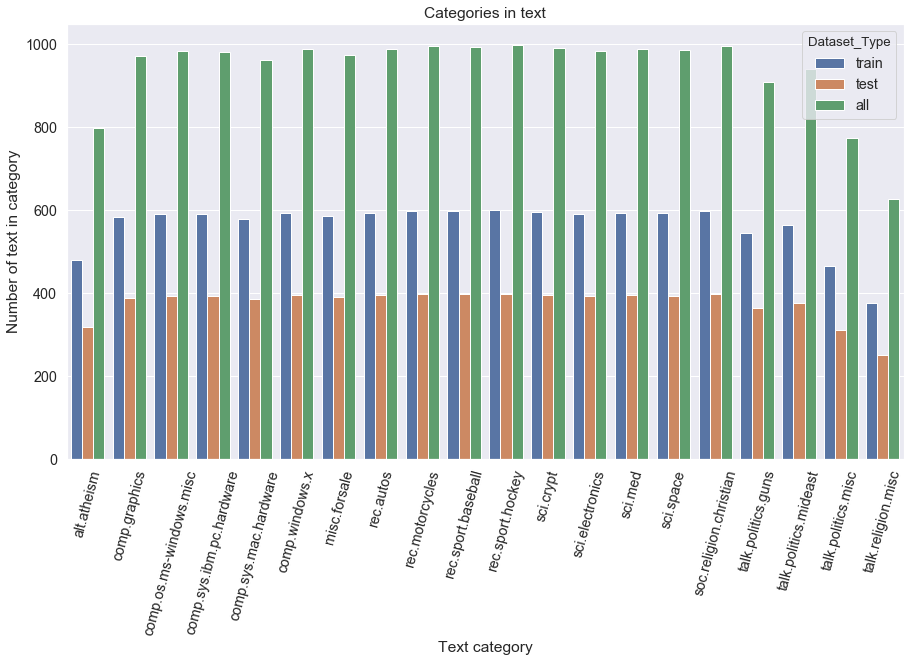

In [388]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", hue = 'Dataset_Type',data=df_summary)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

                   0     1      2     3     4      5     6     7      8   \
High_level_topic  alt   alt    alt  comp  comp   comp  misc  misc   misc   
Dataset_Type      all  test  train   all  test  train   all  test  train   
N_texts           799   319    480  4891  1955   2936   975   390    585   

                    9   ...       11    12    13     14   15    16     17  \
High_level_topic   rec  ...      rec   sci   sci    sci  soc   soc    soc   
Dataset_Type       all  ...    train   all  test  train  all  test  train   
N_texts           3979  ...     2389  3952  1579   2373  997   398    599   

                    18    19     20  
High_level_topic  talk  talk   talk  
Dataset_Type       all  test  train  
N_texts           3253  1301   1952  

[3 rows x 21 columns]


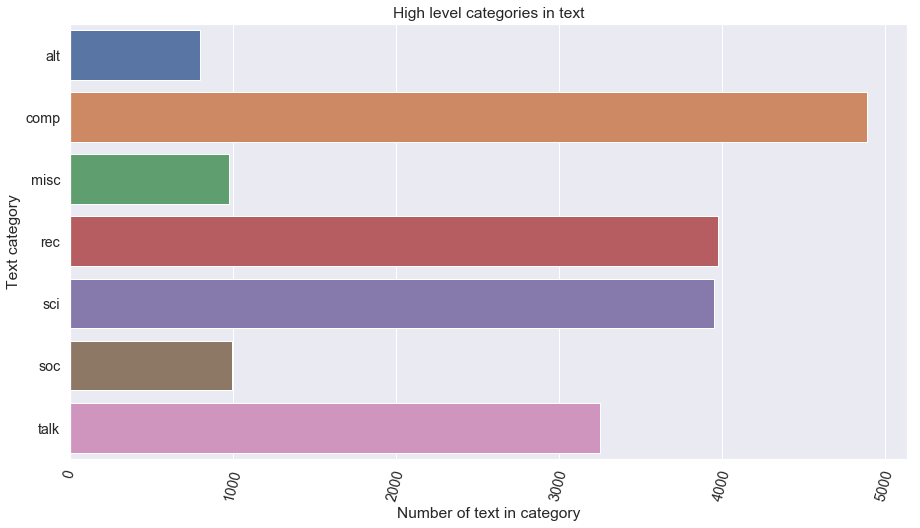

In [828]:
groupped_df = df_summary.groupby(['High_level_topic','Dataset_Type']).agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)
print(groupped_df.T)


plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df[groupped_df.Dataset_Type == 'all'])
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("High level categories in text");

Посмотрим на образец данных.

In [391]:
pprint(newsgroups_all.data[11])

('\n'
 'This is a ridiculous argument for being a Christian.  So then, you might \n'
 'consider switching from Christianity to another religion if you were \n'
 'offered an even more frightening description of another hell?  How many\n'
 'Christians do think there are who view it strictly as an insurance policy?\n'
 'Not many I know; they believe in a message of love and compassion for \n'
 'others.  A faith based on fear of hell sounds like a dysfunctional \n'
 "relationship with God.  Like a child who cringes in fear of a parent's\n"
 'physical violence.  \n'
 '\n'
 'Many religions have concrete views of heaven and hell, with various\n'
 'threats and persuasions regarding who will go where.  Competition over\n'
 'who can envison the worst hell can hardly nurture the idea of loving\n'
 'your neighbor as yourself.\n'
 '\n')


In [392]:
newsgroups_all.target_names[newsgroups_all.target[11]]

'soc.religion.christian'

Текст содержит элементы вида - перенос строки, знаки препинания, имя собественное.

In [1045]:
pprint(newsgroups_all.data[39])

('\n'
 '\n'
 "Again, you missed Jesus's point.  If you read the surrounding passages\n"
 'you would understand what Jesus means by "life in the world."  But\n'
 'as is, you bumbled around, asserted your standard axiom that the Bible is '
 'bunk,\n'
 'and came up with the wrong idea.  Also, you do not know exactly\n'
 'what Jesus means by eternal life.  \n'
 '\n'
 'Brian K., do you expect to jump in the middle of the quantum mechanics\n'
 'book and understand Hermite polynomials having not read the surrounding\n'
 'material?  Why do you such with the Bible?  For an idea what Jesus\n'
 'means by the world, look up references to it in your concordance.  For\n'
 'a good description, the whole Book of Ecclesiastes is game.  For \n'
 'eternal life, check out John 17:3, John 3:15-16.  You will find that\n'
 'eternal life is quite different than what you think.  Eternal life\n'
 'starts NOW--an infinitely high quality of life living in fellowship\n'
 'with God.\n'
 '\n'
 '\n'
 '\n'
 'If my die

In [1044]:
newsgroups_all.target_names[newsgroups_all.target[39]]

'talk.religion.misc'

Помимо элементов из предыдущего текста здесь добавились ..., почтовый адрес и другие шумовые "элементы".

#### Data preprocessing.

Предобработаем данные, для этого:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- заменим представление чисел в виде цифр на текстовые аналоги+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной 2 и менее символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое).

In [1194]:
def remove_emails(text):
    text = re.sub('\S*@\S*\s?','',text)
    
    return text

In [1195]:
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('['+text_punctuation+']', '',text)
    #new_text = re.sub('\n', ' ',new_text)
    #new_text = re.sub('\t', '',new_text)
    new_text =  new_text.strip()
    
    '''for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)'''
    
    return new_text


def remove_punctuation(text_punctuation,text):
    
    new_text = []
    #new_text = re.sub('['+text_punctuation+']', '',text)
    #new_text = re.sub('\n', ' ',new_text)
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text

In [1196]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            if len(word) > 18:
                print (1) #do nothing
            else:
                new_word = p.number_to_words(word)
                new_text.append(new_word)
        else:
            new_text.append(word)
    #del p
    return new_text

In [1197]:
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='v') # pay attention to pos='v' parameter!
        new_text_lemma.append(lemma)
        
        stemm = stemmer.stem(word)
        new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

In [1224]:
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie', 'zsa',
                 '/       \\','0  w','0  w0','000','0000','000000']
StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))

#StopWords.extend(Common_First_Names)

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

In [1225]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

In [1244]:
# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    #  text  to lowercase
    text =  text.lower()
    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 
    
    #ngrams test
    #words = list(ngrams(text.split(), 3))

    # tokenize text
    words = word_tokenize(text,language='english')
    
    #remove punctuation
    #words = remove_punctuation(text_punctuation, words)   
    
    #replace digits with words
    #words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #stemm words 
    #_,words = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 3)

    return words

In [1245]:
'''

sentence = 'this is a foo bar sentences and i want to ngramize it'

n = 3
sixgrams = ngrams(sentence.split(), n)

for grams in sixgrams:
  print (grams)''';

In [1246]:
pprint(newsgroups_all.data[39]) #1,3,55

('\n'
 '\n'
 "Again, you missed Jesus's point.  If you read the surrounding passages\n"
 'you would understand what Jesus means by "life in the world."  But\n'
 'as is, you bumbled around, asserted your standard axiom that the Bible is '
 'bunk,\n'
 'and came up with the wrong idea.  Also, you do not know exactly\n'
 'what Jesus means by eternal life.  \n'
 '\n'
 'Brian K., do you expect to jump in the middle of the quantum mechanics\n'
 'book and understand Hermite polynomials having not read the surrounding\n'
 'material?  Why do you such with the Bible?  For an idea what Jesus\n'
 'means by the world, look up references to it in your concordance.  For\n'
 'a good description, the whole Book of Ecclesiastes is game.  For \n'
 'eternal life, check out John 17:3, John 3:15-16.  You will find that\n'
 'eternal life is quite different than what you think.  Eternal life\n'
 'starts NOW--an infinitely high quality of life living in fellowship\n'
 'with God.\n'
 '\n'
 '\n'
 '\n'
 'If my die

In [1247]:
%%time
test = tokenize(newsgroups_all.data[39])

Wall time: 5.98 ms


In [1248]:
test

['miss',
 'jesuss',
 'point',
 'read',
 'surround',
 'passages',
 'understand',
 'jesus',
 'mean',
 'life',
 'world',
 'bumble',
 'assert',
 'standard',
 'axiom',
 'bible',
 'bunk',
 'come',
 'wrong',
 'idea',
 'know',
 'exactly',
 'jesus',
 'mean',
 'eternal',
 'life',
 'brian',
 'expect',
 'jump',
 'middle',
 'quantum',
 'mechanics',
 'book',
 'understand',
 'hermite',
 'polynomials',
 'read',
 'surround',
 'material',
 'bible',
 'idea',
 'jesus',
 'mean',
 'world',
 'look',
 'reference',
 'concordance',
 'good',
 'description',
 'book',
 'ecclesiastes',
 'game',
 'eternal',
 'life',
 'check',
 'john',
 '173',
 'john',
 '31516',
 'eternal',
 'life',
 'quite',
 'different',
 'think',
 'eternal',
 'life',
 'start',
 'nowan',
 'infinitely',
 'high',
 'quality',
 'life',
 'live',
 'fellowship',
 'god',
 'diety',
 'exist',
 'cease',
 'exist',
 'jesus',
 'talk',
 'hell',
 'luke',
 '161931',
 'truth',
 'sort',
 'magic',
 'spell',
 'truth',
 'understand',
 'enjoy',
 'understand',
 'wrong',
 

#### Classification. Apriory knoweledge.

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

In [1312]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             #min_df=2, # ignore terms with freq less that 0.05, lower majoring
                             #max_df=0.7, # ignore terms with freq more that n, upper majoring
                             max_features=45000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             #ngram_range= (1, 3)
                            )

In [1313]:
%%time
vectorised_train_documents = vectorizer.fit_transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann', 'anne', 'barbara', 'bette', 'carol', 'christophe', 'corinne', 'david', 'diana', 'diane', 'elizabeth', 'elle', 'francois', 'grace', 'hans', 'helen', 'holly', 'jean', 'jeanne', 'john', 'kara', 'kathryn', 'lane', 'lou', 'luc', 'lynn', 'mar', 'marc', 'mari', 'maria', 'marie', 'patrick', 'paul', 'paula', 'peter', 'pierre', 'sara', 'sheila', 'sue', 'terri', 'theresa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 2min 32s


Выделим метки для трейн/тест датасетов.

In [1314]:
y_train, y_test = train_texts.target, test_texts.target

Дополним код вспомогательными функциями, которые будет производить:
- построение матрицы классификации.
- обучение и проверку работы классификатора, с заданными параметрами.

In [1315]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(20,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [1316]:
#simple variant
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='micro')
    
    return f1_train, f1_test, clf

Для удобства, результирующие метрики будем сохранять в df.

In [1317]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score', 'parameters'))

In [1318]:
#variant with pipeline and cv
'''def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 3,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test


alphas = [0.01 , 0.015, 0.02]

for alph in tqdm(alphas):
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score':c, 'parameters':d},ignore_index=True)
    
    ''';

Проверим работу алгоритмов:
- MultinomialNB

In [1319]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,2,5]

for alph in tqdm(alphas):
    f_el = "MultinomialNB"
    s_el,t_el,_ = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)



  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/51 [00:00<00:06,  7.54it/s]

  4%|███▎                                                                               | 2/51 [00:00<00:07,  6.87it/s]

  6%|████▉                                                                              | 3/51 [00:00<00:06,  7.21it/s]

  8%|██████▌                                                                            | 4/51 [00:00<00:06,  7.40it/s]

 10%|████████▏                                                                          | 5/51 [00:00<00:06,  7.39it/s]

 12%|█████████▊                                                                         | 6/51 [00:00<00:05,  7.66it/s]

 14%|███████████▍                                                                       | 7/51 [00:00<00:06,  7.30it/s]

 16%|█████████████            

- BernoulliNB

In [1300]:
for alph in tqdm(alphas):
    f_el = "BernoulliNB"
    s_el,t_el,_ = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)



  0%|                                                                                           | 0/51 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/51 [00:00<00:10,  4.69it/s]

  4%|███▎                                                                               | 2/51 [00:00<00:10,  4.73it/s]

  6%|████▉                                                                              | 3/51 [00:00<00:09,  4.96it/s]

  8%|██████▌                                                                            | 4/51 [00:00<00:09,  5.14it/s]

 10%|████████▏                                                                          | 5/51 [00:00<00:08,  5.26it/s]

 12%|█████████▊                                                                         | 6/51 [00:01<00:08,  5.33it/s]

 14%|███████████▍                                                                       | 7/51 [00:01<00:08,  5.36it/s]

 16%|█████████████            

Выведем наилучший достигнутый результат.

In [1320]:
best_param = results_df[results_df.Test_score ==  results_df.Test_score.max()]['parameters'].values[0]
print (results_df[results_df.Test_score ==  results_df.Test_score.max()])

'''
6    MultinomialNB     0.951741       0.687865  alpha = 0.025
304  MultinomialNB     0.970479       0.687865  alpha = 0.015
16  MultinomialNB     0.938041    0.695035  alpha = 0.075
''';

        Algorithm  Train_score  Test_score     parameters
15  MultinomialNB     0.938748    0.695035   alpha = 0.07
16  MultinomialNB     0.938041    0.695035  alpha = 0.075


Для проверки результатов выведем classification_report и построим матрицу классификации.

                          precision    recall  f1-score   support

             alt.atheism       0.65      0.39      0.49       319
           comp.graphics       0.66      0.67      0.67       389
 comp.os.ms-windows.misc       0.69      0.56      0.62       394
comp.sys.ibm.pc.hardware       0.63      0.70      0.66       392
   comp.sys.mac.hardware       0.73      0.71      0.72       385
          comp.windows.x       0.80      0.74      0.77       395
            misc.forsale       0.82      0.73      0.77       390
               rec.autos       0.79      0.74      0.76       396
         rec.motorcycles       0.78      0.74      0.76       398
      rec.sport.baseball       0.91      0.80      0.85       397
        rec.sport.hockey       0.58      0.94      0.72       399
               sci.crypt       0.68      0.78      0.73       396
         sci.electronics       0.72      0.57      0.64       393
                 sci.med       0.82      0.79      0.80       396
         

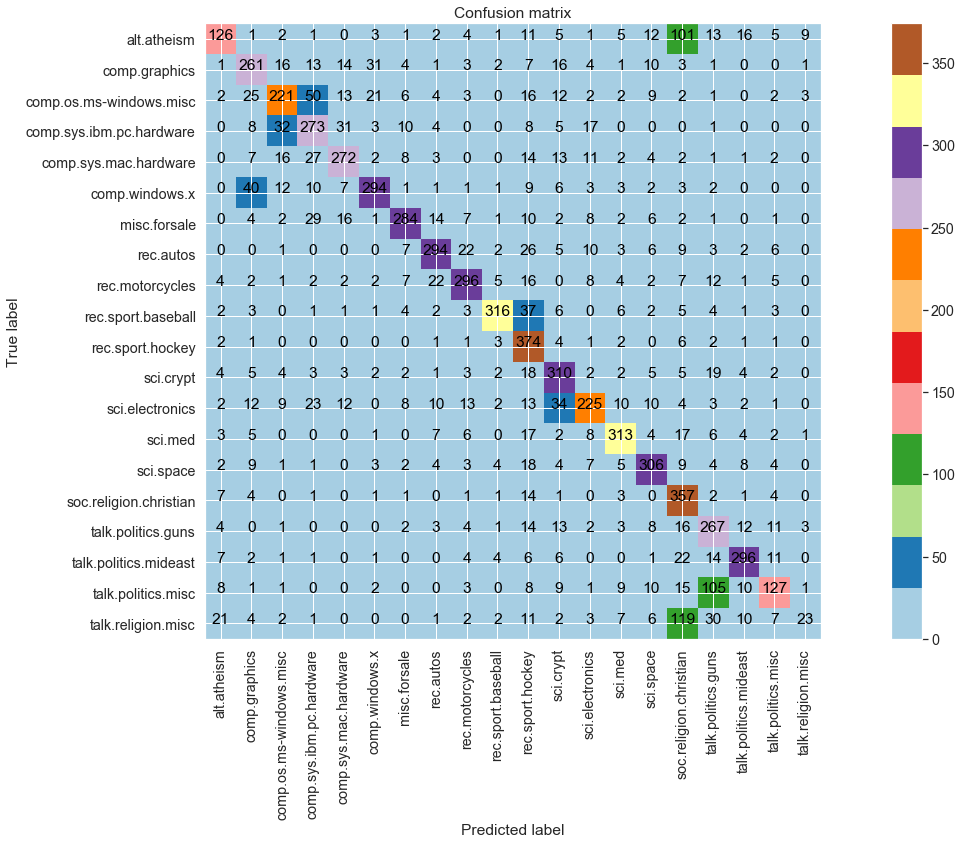

In [1321]:
_,_,clf =  classify_and_score(MultinomialNB(alpha = 0.075), vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,target_names = newsgroups_all.target_names))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = newsgroups_all.target_names))


In [1322]:
len(vectorizer.get_feature_names())

45000

In [1323]:
len(clf.coef_[0])

45000

In [1324]:
sorted(clf.coef_[0],reverse=True)[:10]

print(np.take(vectorizer.get_feature_names(), sorted(clf.coef_[0],reverse=True)[:10]))

[-5.968751000443789,
 -6.102245308955708,
 -6.225642099340744,
 -6.29652856752868,
 -6.51629918981838,
 -6.547076372906087,
 -6.597564375015821,
 -6.6094501864750335,
 -6.685503118750699,
 -6.686387395575418]

['zx10' 'zwarte' 'zwarte' 'zwarte' 'zwarte' 'zwarte' 'zwarte' 'zwarte'
 'zwarte' 'zwarte']


In [1325]:
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()

print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))

['0000' 'org\\ts' 'orgainization' 'orgainizations' 'organ' 'organi'
 'organics' 'organiedcrime' 'org' 'organisations']


In [1326]:
for cls in range(len(clf.coef_)):
    print (cls)
    print (newsgroups_all.target_names[cls])
    neg_class_prob_sorted = clf.coef_[cls, :].argsort()
    #pos_class_prob_sorted = clf.feature_log_prob_[cls, :].argsort()

    print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))
    #print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:10]))

0
alt.atheism
['0000' 'org\\ts' 'orgainization' 'orgainizations' 'organ' 'organi'
 'organics' 'organiedcrime' 'org' 'organisations']
1
comp.graphics
['0000' 'openwindowskeyboardcommands' 'openwinhome' 'openwinhomelibtn'
 'openwinhomesharesrcolitolitbook' 'openwininit' 'openwinolwm' 'oper'
 'openwindowsfocuslenience' 'operable']
2
comp.os.ms-windows.misc
['messier' 'paedophilia' 'paek' 'paeth' 'pagan' 'paganism' 'pagans'
 'paganus' 'padszip' 'pageant']
3
comp.sys.ibm.pc.hardware
['0000' 'outrun' 'outscore' 'outsell' 'outsellin' 'outset' 'outshine'
 'outshoot' 'outright' 'outshooting']
4
comp.sys.mac.hardware
['0000' 'overanalyze' 'overarch' 'overbear' 'overbearingly' 'overbloom'
 'overblown' 'overboard' 'overage' 'overbroad']
5
comp.windows.x
['messier' 'olives' 'olivetti' 'olivia' 'olivier' 'olmasi' 'olmstead'
 'olmus' 'olney' 'olneys']
6
misc.forsale
['0000' 'oses' 'osf' 'osf1' 'osfactivate' 'osfcancel' 'osfdef' 'osfmotif'
 'ose' 'osfmotifs']
7
rec.autos
['0000' 'osinski' 'osipovna' '

In [1327]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [1328]:
show_most_informative_features(vectorizer, clf, n = 30)

	-11.2967	0000           		-5.9688	say            
	-11.2967	000000         		-6.1022	god            
	-11.2967	00000000       		-6.2256	think          
	-11.2967	0000000004     		-6.2965	people         
	-11.2967	00000000b      		-6.5163	post           
	-11.2967	00000001       		-6.5471	religion       
	-11.2967	00000001b      		-6.5976	know           
	-11.2967	00000010       		-6.6095	mean           
	-11.2967	00000010b      		-6.6855	atheists       
	-11.2967	00000011       		-6.6864	atheism        
	-11.2967	00000011b      		-6.6927	believe        
	-11.2967	00000074       		-6.7088	make           
	-11.2967	00000100       		-6.7727	claim          
	-11.2967	00000100b      		-6.8201	morality       
	-11.2967	00000101       		-6.8509	islam          
	-11.2967	00000101b      		-6.8568	objective      
	-11.2967	00000110       		-6.8608	exist          
	-11.2967	00000110b      		-6.8927	like           
	-11.2967	00000111       		-6.8943	bible          
	-11.2967	00000111b      		-6.9

- LinearSVC

#what if l1,l2 or ...loss?

In [120]:
%%time
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]

for c in C_values:
    f_el = "LinearSVC"
    s_el,t_el,_ = classify_and_score(LinearSVC(C=c,random_state=seed,max_iter = 10e3,class_weight = 'balanced'), 
                                   vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

- SVC Kernel Poly

In [128]:
%%time
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0, 40.0, 60.0, 100.0]

for c in tqdm(C_values):
    f_el = "SVC_poly"
    s_el,t_el,_ = classify_and_score(SVC(kernel='poly',gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                   vectorised_train_documents, vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [07:12<00:00, 138.94s/it]


- SVC Kernel Sigmoid and RBF

In [ ]:
kernel = ['rbf','sigmoid']
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.4, 0.5,  0.8, 1.0, 2.0, 5.0, 10.0]

for kern in tqdm(kernels):
    for c in tqdm(C_values):
        f_el = "SVC_" + kern
        s_el,t_el,_ = classify_and_score(SVC(kernel=kern,gamma='scale',C=c,random_state=seed,class_weight = 'balanced'), 
                                       vectorised_train_documents, vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " Kernel = " + kern

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

In [190]:
results_df[results_df.Test_score ==  results_df.Test_score.max()]

,Algorithm,Train_score,Test_score_cv,parameters
29,MultinomialNB,0.948619,0.673413,alpha = 0.07


In [242]:
results_df.to_csv("results_df.csv", sep=';', encoding='utf-8',index = False, header = True)

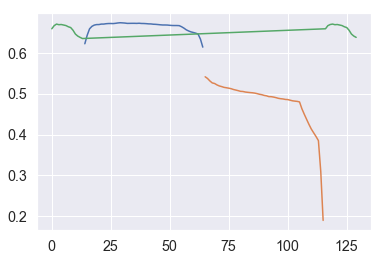

In [240]:
#sns.lineplot(x=results_df.Test_score, hue="Algorithm", lw=1, data=results_df)
#ax = sns.lineplot(y = 'Test_score',data = results_df)
#sns.lineplot(x = results_df.Test_score,data = results_df)
#plt.plot(results_df[results_df.Algorithm == 'SVC_poly']['Test_score'])

In [697]:
#drop svc results
results_df = results_df[results_df.Algorithm !='SGD']

In [712]:
sgd_clf = SGDClassifier(loss = 'modified_huber', penalty = 'elasticnet',
                        alpha = 0.0001, l1_ratio = 0.15,
                        max_iter = 1000, tol = 1e-4,
                        n_jobs = -1, random_state = seed,
                        learning_rate = 'optimal', #adaptive - no profit
                        class_weight = 'balanced', shuffle = True,
                        n_iter_no_change = 100, early_stopping = True
             )

In [723]:
losses = ['hinge','log','modified_huber','squared_hinge','perceptron']
penalties = ['l1','l2','elasticnet']
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3 , 5]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

'''for ls in tqdm(losses):
    f_el = "SGD"
    sgd_clf.loss = ls
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "loss = " + ls
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)''';
for alp in tqdm(alphas):
    for l1 in tqdm(l1_ratios):
        f_el = "SGD"
        sgd_clf.alpha = alp
        sgd_clf.l1_ratio = l1
        s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                         vectorised_test_documents, y_train, y_test)
        f0_el = "alpha = " + str(alp) + " l1_ratio = " + str(l1)
        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)


# compare hinge loss == linear SVM
# compare other different kernels



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:08<01:11,  8.89s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:18<01:03,  9.03s/it]


 33%|████████████████████████████                                                        | 3/9 [00:27<00:54,  9.09s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:36<00:45,  9.04s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:44<00:35,  8.87s/it]


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:57<00:30, 10.02s/it]


 78%|█████████████████

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


 11%|█████████▎                                                                          | 1/9 [00:14<01:56, 14.58s/it]


 22%|██████████████████▋                                                                 | 2/9 [00:30<01:44, 14.98s/it]


 33%|████████████████████████████                                                        | 3/9 [00:43<01:26, 14.49s/it]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:56<01:09, 13.95s/it]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:09<00:54, 13.70s/it]


 67%|████████████████████████████████████████████████████████                            | 6/9 [01:21<00:39, 13.27s/it]


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:35<00:26, 13.47s/it]


 89%|███████████████████

In [715]:
sgd_clf.loss = 'hinge'
#alpha = 0.0001 l1_ratio = 0.01

In [721]:
sgd_clf

                          precision    recall  f1-score   support

             alt.atheism       0.50      0.49      0.50       319
           comp.graphics       0.64      0.64      0.64       389
 comp.os.ms-windows.misc       0.63      0.59      0.61       394
comp.sys.ibm.pc.hardware       0.63      0.60      0.62       392
   comp.sys.mac.hardware       0.70      0.63      0.66       385
          comp.windows.x       0.81      0.72      0.76       395
            misc.forsale       0.71      0.79      0.75       390
               rec.autos       0.77      0.70      0.74       396
         rec.motorcycles       0.49      0.74      0.59       398
      rec.sport.baseball       0.85      0.79      0.82       397
        rec.sport.hockey       0.87      0.88      0.88       399
               sci.crypt       0.80      0.70      0.75       396
         sci.electronics       0.60      0.55      0.57       393
                 sci.med       0.77      0.79      0.78       396
         

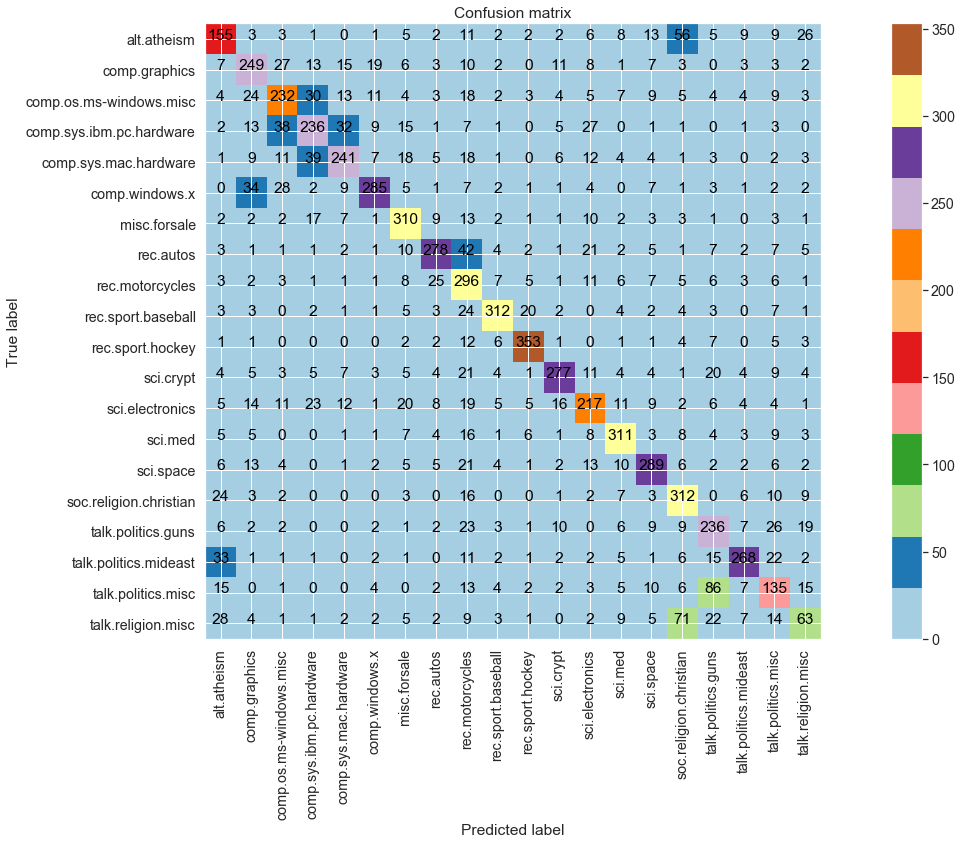

In [717]:
_,_,clf =  classify_and_score(sgd_clf, vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,target_names = newsgroups_all.target_names))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = newsgroups_all.target_names))


GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возросло и привело к тому, что массив не помещяется в память.

In [ ]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')""";

#### Classfication. Without apriory knoweledge.

Your task is to cluster news without prior knowing of original labels. 
And then evaluate performance of your clustering approach: 
1) using original labels 
2) without prior knowledge of labels.

You also may use dimension reduction techniques for visualization purposes, which can give you some insights about data structure.

Scoring:

1) EDA - 2

Text length histogram, words cloud, whatever...
Dimension reduction and visualization
TruncatedSVD
T-SNE or UMAP.

2) Clustering - 3

K-means or MiniBatchKMeans
DBSCAN or HDBSCANС.

3) Performance evaluation -2.

With prior knowledge of ground truth
At least V-measure and adjusted mutual information
Without prior knowledge of ground truth
At least silhouette coefficient
4) Topic modeling - 2

Understand what's the difference between clustering, dimension reduction and topic modeling
Try to use LDA Ссылки на внешний сайт.from Gensim and pyLDAvisСсылки на внешний сайт. for visualization

В этом разделе попробуем классифицировать объекты без знания о принадлежности текстов к какому-либо классу.
Для этого:
- попробуем посмотреть на тексты без знания(EDA), об их принадлежности классам.
- сократим размерность (TruncatedSVD)  и попробуем визуализировать структуру данных (T-SNE or UMAP).  
- Попробуем выделить классы при помощи K-means or MiniBatchKMeans;DBSCAN or HDBSCANС.